In [1]:
import pandas as pd
import torch
import torch.nn as nn
from normalization import Input_output_data

df = pd.read_csv('/Users/bloodytaken/graduate_project/data/MSD/MSD_nonlinear_noiseless_k_010.csv')

# Extract data
u = torch.tensor(df['Input'].values, dtype=torch.float32).view(-1, 1)  
y = torch.tensor(df['Output'].values, dtype=torch.float32).view(-1, 1)  
delta_t = torch.tensor(df['Delta_t'].values, dtype=torch.float32).view(-1, 1)  
# delta_t = torch.cat([delta_t[1:], torch.tensor([[0.0]])], dim=0) # shift one step
# data = Input_output_data(u, y, delta_t, name='irregular_sampling')

# For test below
state_cols = [c for c in df.columns if c.startswith('TrueState_')]
x = torch.tensor(df[state_cols].values, dtype=torch.float32)   # (N , nx)

print(u.shape, y.shape, delta_t.shape, x.shape)   #  sanity-check
data = Input_output_data(u, y, delta_t, x=x, name='irregular_sampling')

# Split dataset
train, val, test  = data[:10000], data[10000:12000], data[12000:]
print(f'{train = }')
print(f'{val = }')
print(f'{test = }')



torch.Size([20000, 1]) torch.Size([20000, 1]) torch.Size([20000, 1]) torch.Size([20000, 0])
train = Input_output_data "irregular_sampling" u.shape=torch.Size([10000, 1]), y.shape=torch.Size([10000, 1]), sampling_time varying, length=10000
val = Input_output_data "irregular_sampling" u.shape=torch.Size([2000, 1]), y.shape=torch.Size([2000, 1]), sampling_time varying, length=2000
test = Input_output_data "irregular_sampling" u.shape=torch.Size([8000, 1]), y.shape=torch.Size([8000, 1]), sampling_time varying, length=8000


In [2]:
std_delta_t = torch.std(delta_t)
var_delta_t = torch.var(delta_t)

print(f"Standard deviation of Delta_t: {std_delta_t.item()}")
print(f"Variance of Delta_t: {var_delta_t.item()}")


Standard deviation of Delta_t: 0.10068249702453613
Variance of Delta_t: 0.010136964730918407


Number of samples to train on = 9946


  0%|          | 0/40000 [00:00<?, ?it/s]

it       0 NRMS loss nan NRMS val nan   nan samps/sec
it     100 NRMS loss 1.45146 NRMS val 0.79622!! 1291.34 samps/sec
it     200 NRMS loss 0.82732 NRMS val 0.76288!! 1303.79 samps/sec
it     300 NRMS loss 0.74957 NRMS val 0.55371!! 1311.30 samps/sec
it     400 NRMS loss 0.49013 NRMS val 0.29551!! 1312.54 samps/sec
it     500 NRMS loss 0.37966 NRMS val 0.25540!! 1302.46 samps/sec
it     600 NRMS loss 0.31705 NRMS val 0.22041!! 1294.85 samps/sec
it     700 NRMS loss 0.27437 NRMS val 0.18677!! 1290.85 samps/sec
it     800 NRMS loss 0.24149 NRMS val 0.16075!! 1287.59 samps/sec
it     900 NRMS loss 0.21882 NRMS val 0.14240!! 1285.19 samps/sec
it   1,000 NRMS loss 0.19987 NRMS val 0.13960!! 1284.39 samps/sec
it   1,100 NRMS loss 0.18806 NRMS val 0.11198!! 1282.63 samps/sec
it   1,200 NRMS loss 0.17579 NRMS val 0.10185!! 1285.10 samps/sec
it   1,300 NRMS loss 0.16758 NRMS val 0.09454!! 1287.11 samps/sec
it   1,400 NRMS loss 0.16069 NRMS val 0.08795!! 1286.89 samps/sec
it   1,500 NRMS loss 0

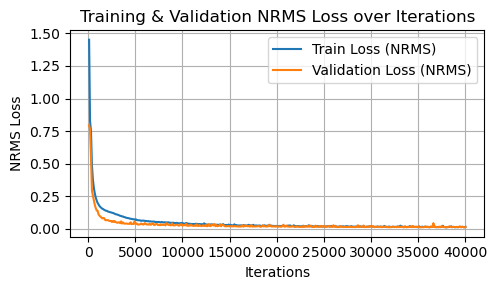

In [3]:

from normalization import get_nu_ny_and_auto_norm
from models import SUBNET_ISTS
from networks import rk4_integrator

nu, ny, norm = get_nu_ny_and_auto_norm(train)

torch.manual_seed(1)
model = SUBNET_ISTS(nu, ny, norm, nx=2, na=5, nb=5, integrator=rk4_integrator)
from fitting import fit
train_dict = fit(model, train=train, val=val, n_its=40000, T=50, batch_size=64, val_freq=100)


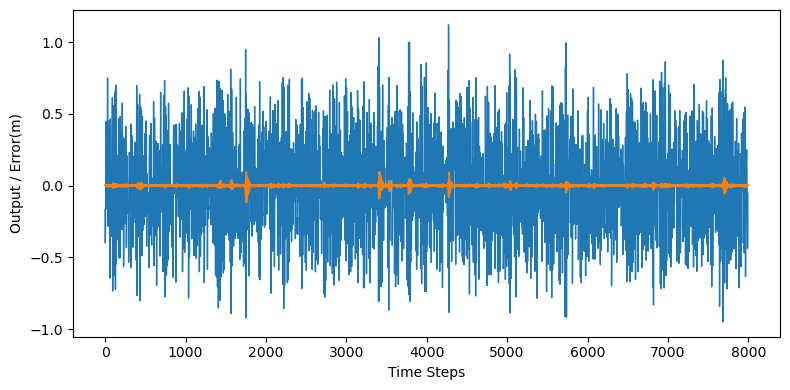

NRMS = 2.51%
RMSE = 0.0080 m


In [4]:
from matplotlib import pyplot as plt

# 模拟
test_sim = model.simulate(test)

# 对齐
y_true = test.y[model.na:]
y_pred = test_sim.y[model.na:]

# 转 numpy
if hasattr(y_true, 'detach'):
    y_true = y_true.detach().cpu().numpy()
if hasattr(y_pred, 'detach'):
    y_pred = y_pred.detach().cpu().numpy()

# 计算残差
residual = y_true - y_pred

# 一张图绘制
plt.figure(figsize=(8, 4))
# plt.plot(y_pred, label='Irregular SUBNET model',linewidth=1.5)
plt.plot(y_true, label='Measurements', linewidth=1)
plt.plot(residual, label='Irregular SUBNET Residual', linewidth=1.5)

# plt.title('True vs Predicted with Residual')
plt.xlabel('Time Steps')
plt.ylabel('Output / Error(m)')
# plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()

# 误差指标
from nonlinear_benchmarks.error_metrics import NRMSE, RMSE
print(f'NRMS = {NRMSE(y_true, y_pred)[0]:.2%}')
print(f'RMSE = {RMSE(y_true, y_pred)[0]:.4f} m')


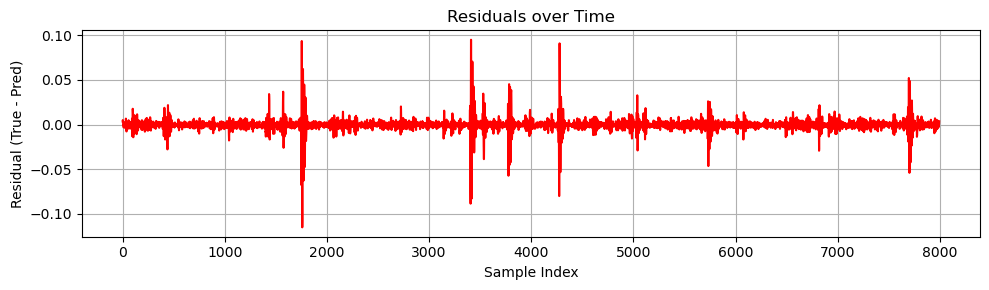

In [6]:
residuals = y_true - y_pred
plt.figure(figsize=(10, 3))
plt.plot(residuals, color='red')
plt.title('Residuals over Time')
plt.xlabel('Sample Index')
plt.ylabel('Residual (True - Pred)')
plt.grid(True)
plt.tight_layout()
plt.show()


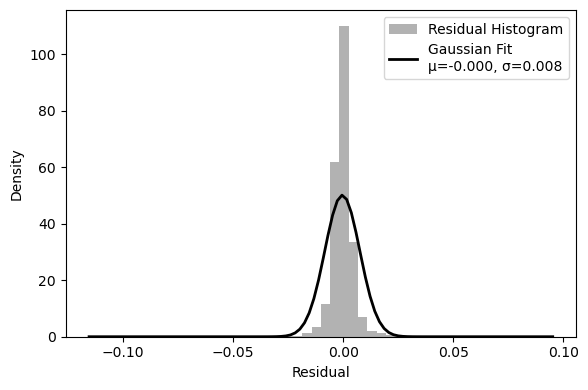

In [7]:
import numpy as np
from scipy.stats import norm

mu, sigma = norm.fit(residuals)
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=50, density=True, alpha=0.6, color='gray', label='Residual Histogram')
x_vals = np.linspace(residuals.min(), residuals.max(), 100)
plt.plot(x_vals, norm.pdf(x_vals, mu, sigma), 'k', linewidth=2, label=f'Gaussian Fit\nμ={mu:.3f}, σ={sigma:.3f}')
# plt.title('Residual Histogram with Gaussian Fit')
plt.xlabel('Residual')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()


| Method         | k | NRMS (%) | RMSE (m) |
| :--------------- | :---------------- | :------- | :------- |
| **Irregular Subnet** |                   |          |          |
|                  | Equidistantly Sampled | 1.11     | 0.0033   |
|                  | k=0.01            | 0.95     | 0.0029   |
|                  | k=0.05            | 1.78     | 0.0054   |
|                  | k=0.1             | 2.51     | 0.0080   |
|                  | k=0.2             | 3.52     | 0.0114   |
|                  | k=0.4             | 3.67     | 0.0137   |
| **Subnet** |                   |          |          |
|                  | Equidistantly Sampled | 7.30     | 0.0218   |
|                  | k=0.001           | 10.42    | 0.0323   |
|                  | k=0.005           | 34.47    | 0.1053   |
|                  | k=0.1             | 52.054   |  |
|                  | k=0.2             | 74.659   | |
|                  | k=0.4             | 90.12    | 0.3352   |